In [1]:
import qiskit; import numpy as np; import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer, execute
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.circuit import ParameterVector
from qiskit import qpy

from qoop.core import state, ansatz
from qoop.compilation.qcompilation import QuantumCompilation
from qoop.compilation.qst import QuantumStateTomography
from qoop.compilation.qsp import QuantumStatePreparation
from qoop.backend import utilities
from qoop.evolution.environment_synthesis import MetadataSynthesis
from qoop.evolution.generator import by_num_rotations,by_num_rotations_and_cnot
from qoop.evolution.environment import EEnvironment


In [2]:
def fitnessW(qc: qiskit.QuantumCircuit):
    qsp = QuantumStatePreparation(
        u = qc,
        target_state = state.w(num_qubits = 3).inverse()
    ).fit(num_steps = 100)
    return 1 - qsp.compiler.metrics['loss_fubini_study'][-1] # Fitness value

env_metadata = MetadataSynthesis(
    num_qubits = 3, # As its name
    num_cnot= 10,
    depth = 10, # Ansatz depth you want
    num_circuit = 8, # Number of ansatz per generation
    num_generation = 10, # Number of generation/iteration for GA
    prob_mutate = 0.01 # Mutation probability, usually as small as 0.01 (1%)
)

"""env = EEnvironment(
    metadata = env_metadata,
    fitness_func = fitnessW,
).evol()"""

'env = EEnvironment(\n    metadata = env_metadata,\n    fitness_func = fitnessW,\n).evol()'

5


d:\Anaconda-Env\GAqiskit\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


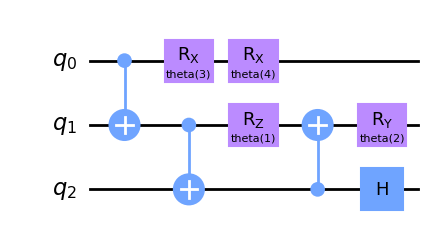

In [3]:
env_metadata = MetadataSynthesis(
    num_qubits=3,
    num_cnot=3,
    num_rx=2,
    num_ry=1,
    num_rz=1,
    depth=5,
    num_circuit=4,
    num_generation=10,
    prob_mutate=0.01
)

from qoop.evolution.generator import by_num_rotations

qc = by_num_rotations_and_cnot(env_metadata)
print(qc.depth())
qc.draw('mpl')

9


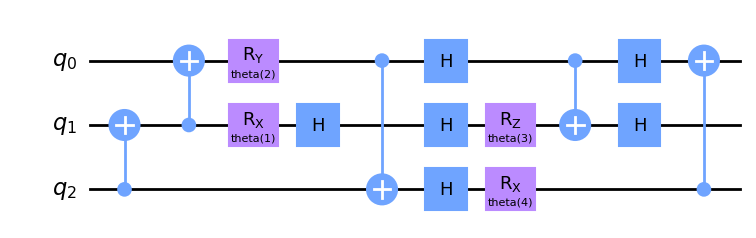

In [4]:
env_metadata = MetadataSynthesis(
    num_qubits=3,
    num_cnot=3,
    num_rx=2,
    num_ry=1,
    num_rz=1,
    depth=5,
    num_circuit=4,
    num_generation=10,
    prob_mutate=0.01
)

from qoop.evolution.generator import by_num_rotations

qc = by_num_rotations(env_metadata)
print(qc.depth())
qc.draw('mpl')

In [5]:
def generate_data(n_samples,n_features,centers, random_state):
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, random_state=random_state)
    y = 2 * y - 1  # Convert labels to {-1, +1} for compatibility with QSVC
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

X_train,X_test,y_train, y_test = generate_data(n_samples=100, n_features=2, centers=2, random_state=41)
feature_dimension = 2
FeatureM = ZZFeatureMap(feature_dimension=2, reps=1)

def Define_Eval_QSVM(feature_dimension):
    # Step 2:

    #FeatureM = ZZFeatureMap(feature_dimension=feature_dimension, reps=num_rep)
    # Step 3: Use QuantumKernel to compute the kernel matrix
    qasm = Aer.get_backend('statevector_simulator')
    quantum_kernel = QuantumKernel(feature_map=feature_dimension,quantum_instance=qasm) # Encode each data point into each separated state (500 data points -> 500 states) 
    #and create K(xi,xj) = [state ij;...], is computing each state with each other, 500 states -> K matrix (500x500)

    # Step 4: Train a QSVM
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train, y_train) #fit(df_train[features], df_train['Species'])

    # Step 5: Evaluate the QSVM
    accuracy = qsvc.score(X_test, y_test)
    return accuracy


def load_circuits(fitness_levels):
    circuits = []
    for fitness in range(1, fitness_levels+1):
        print(fitness)
        file_name = f'4qubits_FM{fitness}_fitness_2024-12-02/best_circuit.qpy'
        with open(file_name, 'rb') as fd:
            circuit = qpy.load(fd)[0]
            print(circuit)  # Print if needed
            circuits.append(circuit)
    return circuits

In [7]:
env_metadata = MetadataSynthesis(
    num_qubits=2,
    num_cnot=3,
    #num_rx=2,
    #num_ry=1,
    num_rz=2,
    depth=5,
    num_circuit=4,
    num_generation=10,
    prob_mutate=0.01
)

env = EEnvironment(
    metadata = by_num_rotations_and_cnot(env_metadata),
    fitness_func = Define_Eval_QSVM,
).evol()
print()

AttributeError: 'QuantumCircuit' object has no attribute 'current_generation'